В этой тетрадке мы будем создавать тексты постов.

Начнем с простого способа, а закончим генерацией текстов с помощью нейросетей. :)

## 1. Марковские цепи(из коробки)

In [1]:
import markovify

In [2]:
def load_texts(name='data.txt'):
    with open(name) as f:
        return [x.strip() for x in f.readlines()]

In [3]:
texts = load_texts()
chain = markovify.Text(texts)

Сгенерируем 7 предложений при помощи полученной марковской цепи

In [4]:
n = 7
i = 0
while True:
    if i >= n:
        break
    sent = chain.make_sentence()
    if sent is None:
        continue
    print('sentence %d:' % (i + 1))
    print(sent, end="\n\n")
    i += 1

sentence 1:
А ведь самые красивые девушки — только у нас!

sentence 2:
А ведь самые красивые девушки учатся на матфаке!

sentence 3:
А ведь самые красивые девушки учатся на матфаке.

sentence 4:
Еще помните, где учатся самые красивые девушки учатся на матфаке!И, между прочим, хорошо учатся!

sentence 5:
Еще помните, где учатся самые красивые девушки учатся у нас.

sentence 6:
А ведь самые красивые девушки?

sentence 7:
А ведь самые красивые девушки учатся на матфаке!



Чтобы немного увеличить датасет будем использовать выкачанные эпитеты(в прошлой тетрадке проводилась слабая предобработка).

In [5]:
import pymorphy2
from nltk import word_tokenize
import numpy as np

morph = pymorphy2.MorphAnalyzer()

In [6]:
adjs = load_texts('some_adj.txt')

In [7]:
def augment(s):
    rows = [word_tokenize(x) for x in s]
    strs = []
    for r in rows:
        for i in range(len(r)):
            if morph.tag(r[i])[0].POS == 'ADJF':
                for j in range(50):
                    t = r.copy()
            
                    tag = morph.tag(t[i])[0]
                    gramms = tag.grammemes
                    rnd_word = morph.parse(np.random.choice(adjs, replace=True))[0]
                    new_word = rnd_word.inflect(gramms)
                    if new_word is None:
                        continue
                    t[i] = new_word.word
                    string = u''
                    for j in range(len(r)):
                        if str(morph.tag(t[j])[0]) == 'PNCT':
                            string += t[j]
                        else:
                            string += u' ' + t[j]
                    strs.append(string.strip())
    strs.extend(s)
    return strs

In [8]:
%%time
augmented = augment(texts)

CPU times: user 4.97 s, sys: 0 ns, total: 4.97 s
Wall time: 5.14 s


In [9]:
def save_texts(texts, name='augmented.txt'):
    with open(name, 'w') as f:
        f.write('\n'.join(texts))
        
save_texts(augmented)

Взглянем на результат!..

In [380]:
augmented[:2]

['А ведь самые удивительные девушки учатся у нас!',
 'А ведь самые креативные девушки учатся у нас!']

In [15]:
chain1 = markovify.Text(augmented)

In [16]:
n = 7
i = 0
while True:
    if i >= n:
        break
    sent = chain1.make_sentence()
    if sent is None:
        continue
    print('sentence %d:' % (i + 1))
    print(sent, end="\n\n")
    i += 1

sentence 1:
Самые восточные и удивительные девушки учатся на матфаке и ходят в фирменных футболках ИМИТ!

sentence 2:
А ведь самые сердечные девушки учатся на матфаке.

sentence 3:
А ведь самые лихие девушки учатся на матфаке?

sentence 4:
Самые добрые и удивительные девушки учатся у нас.

sentence 5:
Самые честолюбивые девушки учатся у нас!

sentence 6:
Самые обманчивые девушки учатся у нас!

sentence 7:
Самые пластичные девушки учатся у нас.



Хех 8)<br>
Забавно, хорошечно!

Теперь попробуем более замудренный вариант генерации подобных постов.

## 2. Char-level RNN

Данный фрагмент тетрадки основан на <a href="https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html">туторе из документации PyTorch</a>, но наш пример проще.

Натравим Vanilla RNN на генерацию постов!

In [20]:
import torch
from torch import nn

In [30]:
all_chars = ''.join(set(''.join(augmented)))
n_chars = len(all_chars) + 1
print(n_chars)

93


In [31]:
def random_example():
    text = augmented[np.random.randint(0, len(augmented))]
    return text

In [49]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_chars)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_chars.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_chars.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_chars - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [50]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = random_example()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [71]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [81]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    torch.nn.utils.clip_grad_norm_(rnn.parameters(), 150)
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [82]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [83]:
%%time
from tqdm import tqdm_notebook

rnn = RNN(n_chars, 128, n_chars)

n_iters = 100000
print_every = 500
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in tqdm_notebook(range(1, n_iters + 1)):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 33s (500 0%) 3.4234
1m 12s (1000 1%) 2.5197
1m 56s (1500 1%) 1.3148
2m 37s (2000 2%) 1.1514
3m 19s (2500 2%) 1.7860
4m 7s (3000 3%) 1.4363
4m 49s (3500 3%) 1.7283
5m 30s (4000 4%) 1.1062
6m 17s (4500 4%) 0.8738
7m 4s (5000 5%) 1.0150
7m 51s (5500 5%) 0.8243
8m 40s (6000 6%) 0.5487
9m 28s (6500 6%) 0.6510
10m 11s (7000 7%) 1.7874
10m 57s (7500 7%) 1.0171
11m 46s (8000 8%) 1.0037
12m 32s (8500 8%) 1.3180
13m 16s (9000 9%) 0.4659
13m 57s (9500 9%) 1.3168
14m 50s (10000 10%) 1.2021
15m 39s (10500 10%) 0.7185
16m 26s (11000 11%) 0.9242
17m 14s (11500 11%) 0.7445
18m 2s (12000 12%) 1.5318
18m 54s (12500 12%) 1.2056
19m 44s (13000 13%) 0.8723
20m 29s (13500 13%) 1.0718
21m 21s (14000 14%) 1.1220
22m 15s (14500 14%) 1.1002
22m 57s (15000 15%) 0.7105
23m 45s (15500 15%) 0.4661
24m 33s (16000 16%) 0.9879
25m 25s (16500 16%) 0.8762
26m 10s (17000 17%) 0.9272
26m 57s (17500 17%) 0.6406
27m 46s (18000 18%) 0.8268
28m 35s (18500 18%) 1.2909
29m 19s (19000 19%) 0.7623
30m 7s (19500 19%) 0.8667
30m

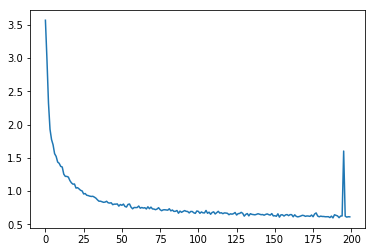

In [85]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses);

In [96]:
max_length = 70


def sample(start_letter='С'):
    with torch.no_grad():
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_chars - 1:
                break
            else:
                letter = all_chars[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

    
def samples(start_letters='Сскд'):
    for start_letter in start_letters:
        print(sample(start_letter))

In [97]:
samples()

Самые красивые и нерастие делушке учстся на мо:фаkе инальные девушки уч
самнные девушки учатся на мастакиатые девдевушки учатся на матфаке.
ковые девушки учатся нанмые ккасивые пельшки учистяена матфаке!
давыль сумые изаротные деудивительные девушки учаpся на матфакG!


Воу! Получилось прикольно, но жутко.

Поэтому давайте вместо Vanilla RNN будем использовать LSTM?(но дальше мы будем генерировать пост из слов, а не посимвольно)

## Word-level LSTM

Based on <a href="https://medium.freecodecamp.org/applied-introduction-to-lstms-for-text-generation-380158b29fb3">link #1</a>, <a href="https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275">link #2</a>.

In [343]:
from keras.models import Sequential
from keras.layers import Dropout, TimeDistributed
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Embedding
from keras.layers import Densу
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint

In [344]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [345]:
new_texts = [word_tokenize(x.lower()) for x in augmented]

In [346]:
tokenizer = Tokenizer()
def dataset_preparation(data):
    corpus = data
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    input_sequences = []
    
    for line in new_texts:
        
        token_list = tokenizer.texts_to_sequences([line])[0]
        
        for i in range(1, len(token_list)):
            
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            
            if True:#np.random.normal() > -0.1:
                
                for j in range(i):
                    if abs(j - i) > 2 and abs(j - i) < len(token_list) // 2:
                        
                        n_gram_sequence = token_list[j:i+1]
                        input_sequences.append(n_gram_sequence)
    
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(
        pad_sequences(
            input_sequences,   
            maxlen=max_sequence_len, 
            padding='pre')
    )
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = np_utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len, total_words

In [347]:
def create_model(max_sequence_len, total_words):
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
    model.add(LSTM(150, return_sequences=True))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(LSTM(100))
    model.add(Dense(total_words, activation='softmax'))

    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [348]:
from keras.callbacks import EarlyStopping

In [349]:
def generate_text(seed_text, next_words, max_sequence_len):
    for j in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen= 
                             max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
  
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [350]:
%%time
X, Y, max_len, total_words = dataset_preparation(new_texts)

CPU times: user 1.46 s, sys: 83.2 ms, total: 1.54 s
Wall time: 1.53 s


In [351]:
model = create_model(max_len, total_words)

In [352]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 53, 10)            3570      
_________________________________________________________________
lstm_62 (LSTM)               (None, 53, 150)           96600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 53, 150)           0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 100)               100400    
_________________________________________________________________
dense_31 (Dense)             (None, 357)               36057     
Total params: 236,627
Trainable params: 236,627
Non-trainable params: 0
_________________________________________________________________


In [353]:
def on_epoch_end(epoch, logs):
    print()
    print('----- Generating text after Epoch: %d' % (epoch + 1))
    print(generate_text('самые', 54, 54))
    print('--------------------------------------')
    print(generate_text('красивые', 54, 54))
    print('--------------------------------------')
    print(generate_text('великолепные', 54, 54))
    print('--------------------------------------')
    print(generate_text('у нас', 54, 54))
    print('--------------------------------------')

In [354]:
np.random.seed(442)


generating_text = LambdaCallback(on_epoch_end=on_epoch_end)

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

model.fit(X, Y,
          batch_size=128,
          epochs=100,
          verbose=1,
        callbacks=[checkpoint, earlystop, generating_text])

Epoch 1/100
117362/117362 [==============================] - 525s 4ms/step - loss: 0.6689 - acc: 0.8525

Epoch 00001: loss improved from inf to 0.66886, saving model to weights.hdf5

----- Generating text after Epoch: 1
самые красивые девушки учатся на матфаке и ходят в фирменных футболках имит ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
красивые самые красивые девушки учатся на матфаке и ходят в фирменных футболках имит ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
великолепные самые красивые девушки учатся на матфаке и ходят в фирменных футболках имит ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
у нас ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
Epoch 

117362/117362 [==============================] - 464s 4ms/step - loss: 0.1546 - acc: 0.9727

Epoch 00010: loss did not improve from 0.14528

----- Generating text after Epoch: 10
самые красивые девушки учатся на матфаке и ходят в фирменных футболках имит ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
красивые у нас ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
великолепные помните , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
--------------------------------------
у нас ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------
Epoch 11/100
117362/117362 [==============================] - 461s 4ms/step - loss: 0.1506 - acc: 0.9732

Epoch 00011: loss did not improve fro

In [355]:
generate_text('футболках', 5, 54)

'футболках имит ! ! ! !'

In [376]:
generate_text('самые прекрасные', 5, 54)

'самые прекрасные и удивительные девушки учатся на'

In [507]:
for x in [
    'самые',
    'самые прекрасные',
    'девушки',
    'удивительные',
    'у нас',
    'учатся',
    'у нас на матфаке'
]:
    print(generate_text(x, np.random.randint(5, 15), 54))

самые красивые девушки учатся на матфаке и ходят в фирменных футболках имит ! !
самые прекрасные и удивительные девушки учатся на матфаке ! ! !
девушки у нас '' постоянно пополняется ,
удивительные матфаке ! ! ! ! ! ! ! ! ! ! ! ! !
у нас ! ! ! ! ! ! ! ! ! ! ! ! !
учатся у нас '' постоянно пополняется , , , ,
у нас на матфаке и ходят в фирменных футболках


Таким образом мы получили некоторую "модель языка" данных постов.